# DLCV Assignment 1

**Due Date: 17/02/2023 11:59PM IST**

**Name: B ASHOK**

**Sr.No.: 21032**




In this assignment, we will cover the following topics:

1) Training a simple Linear Model 

2) Implementing Modules with Backprop functionality

3) Implementing Convolution Module on Numpy


It is crucial to get down to the nitty gritty of the code to implement all of these. No external packages (like caffe,pytorch etc), which directly give functions for these steps, are to be used. 

## Training a simple Linear Model

In this section, you will write the code to train a Linear Model. The goal is to classify an input $X_i$ of size $n$ into one of $m$ classes. For this, you need to consider the following:

1)  **Weight Matrix** $W_{n\times m}$: The Weights are multipled with the input $X_i$ (vector of size $n$), to find $m$ scores $S_m$ for the $m$ classes.

2)  **The Loss function**:   
  * The Cross Entropy Loss: By interpreting the scores as unnormalized log probabilities for each class, this loss tries to measure dissatisfaction with the scores in terms of the log probability of the right class:

$$
L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right) \hspace{0.5in} \text{or equivalently} \hspace{0.5in} L_i = -f_{y_i} + \log\sum_j e^{f_j}
$$

where $f_{ y_i }$ is the $y_i$-th element of the output of $W^T  X_i$

3) **A Regularization term**: In addition to the loss, you need a Regularization term to lead to a more distributed (in case of $L_2$) or sparse (in case of $L_1$) learning of the weights. For example, with $L_2$ regularization, the loss has the following additional term:

$$
R(W) = \sum_k\sum_l W_{k,l}^2  
$$

Thus the total loss has the form:
$$
L =  \underbrace{ \frac{1}{N} \sum_i L_i }_\text{data loss} + \underbrace{ \lambda R(W) }_\text{regularization loss} \\\\
$$

4) **An Optimization Procedure**: This refers to the process which tweaks the weight Matrix $W_{n\times m}$ to reduce the loss function $L$. In our case, this refers to Mini-batch Gradient Descent algorithm. We adjust the weights $W_{n\times m}$, based on the gradient of the loss $L$ w.r.t. $W_{n\times m}$. This leads to:
$$
W_{t+1} = W_{t} - \alpha \frac{\partial L}{\partial W},
$$
where $\alpha$ is the learning rate. Additionally, with "mini-batch" gradient descent, instead of finding loss over the whole dataset, we use a small sample $B$ of the training data to make each learning step. Hence,
$$
W_{t+1} = W_{t} - \alpha \frac{\partial \sum_{i \in B}{L_{x_i}}}{\partial W},
$$
where $|B|$ is the batch size.

# Question 1



Train a **Single-Layer Classifier** for the MNIST dataset. 
* Use Softmax-Loss.
* Maintain a train-validation split of the original training set for finding the right value of $\lambda$ for the regularization, and to check for over-fitting.
* Finally, evaluate the classification performance on the test-set.


## main ( loading data )

In [3]:
# imports 
import numpy as np 
import matplotlib.pyplot as plt 
import torchvision.datasets as datasets

from sklearn.model_selection import train_test_split

In [4]:

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

# train-val split
mnist_trainset, mnist_valset =  train_test_split(mnist_trainset, test_size=0.2, random_state=42)

In [5]:
mnist_testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [6]:
def get_minibatch( training_set = mnist_trainset, batch_size = 64):
    """ suffle the training_set and return a generator of minibatches with tuple of (x, y) """
    np.random.shuffle(training_set)
    
    for i in range(0, len(training_set), batch_size):
        yield training_set[i:i+batch_size] 

## single_layer_classifier class

In [7]:
# Define the class for a Single Layer Classifier
class Single_layer_classifier():
    
    def __init__(self, input_size, output_size,SIGMA = 1e-5):
        
        self.input_size = input_size
        self.output_size = output_size
        self.W = np.random.normal(0, SIGMA, (input_size, output_size))
        self.W_grad = np.zeros(shape = (self.W.shape))
        self.x = None
        
        # Give the instance a weight matrix, initialized randomly
        # One possible strategy for a good initialization is Normal (0, σ) where σ = 1e-3.
        # Try experimenting with different values of σ.
    def update_weights(self,lr = 0.001):
      self.W -= self.W_grad * lr 
      self.W_grad = np.zeros(shape = (self.W.shape))
        
    # Define the forward function
    def forward(self, input_x):
        """ input_x : image of shape (1, 28, 28)
            returns : scores of shape (10, )
        """
        # flatten the input to 1D
        input_x = np.array(input_x).flatten()
        self.x = input_x 
        # get the scores
        scores = np.dot(self.W.T, input_x)        
        scores = scores.reshape(-1)
        return scores
    
    # Similarly a backward function
    # we define 2 backward functions (as Loss = L_data + L_reg, grad(Loss) = grad(L1) + grad(L2))
    
    def backward_Ldata(self, grad_from_loss):
        """ grad_from_loss : numpy array of 1D of shape (10, )
            returns : grad_matrix : numpy array of 2D of shape (784, 10)
        """
        
        # this function returns a matrix of the same size as the weights, 
        # where each element is the partial derivative of the loss w.r.t. the corresponding element of W

        grad_matrix = np.outer( self.x, grad_from_loss )
        
        return grad_matrix
        
    def backward_Lreg(self,reg_coeff = 1):
        """
            reg_coeff : regularization coefficient
            returns : grad_matrix : numpy array of 2D of shape (784, 10)
        """
        # this function returns a matrix of the same size as the weights, 
        # where each element is the partial derivative of the regularization-term
        # w.r.t. the corresponding element of W

        # for L2 loss 
        grad_matrix = 2 * reg_coeff * self.W
        
        return grad_matrix

##loss_function

In [8]:
# Implement the Softmax loss function
def loss_function(input_y,scores):
    """ don't change these. write seperate func. for Q3

    input_y : label of the image (int)
    scores : numpy array of 1D of shape (10, )
    returns : loss : float
    """

    y_i = input_y 
    # to avoid overflow
    s_max = np.max(scores)
    scores_reduced = scores - s_max
    # print("s_max:",s_max) #debug
    temp = s_max + np.log( np.exp(scores_reduced).sum() )
    loss = -1* scores[y_i] + temp #np.log( np.sum( np.exp( scores )))
        
    return loss
# def loss_backward(loss):

def loss_backward(input_y,scores):
    """ gradient depends on scores and label_y .
    input_y : label of the image (int)
    scores : numpy array of 1D of shape (10, )
    returns : grad_from_loss : numpy array of 1D of shape (10, )
    """ 
    # This part deals with the gradient of the loss w.r.t the output of network
    # for example, in case of softmax loss(-log(q_c)), this part gives grad(loss) w.r.t. q_c
    # pass this to backward_ldata

    ## gradient of softmax loss wrt scores
    # to avoid overflow
    s_max = np.max(scores)
    scores_reduced = scores - s_max

    temp = (1/np.sum( np.exp( scores_reduced )) ) * np.exp(scores_reduced )
    temp[input_y] += ( -1 )
    grad_from_loss = temp     

    return grad_from_loss
        

## looped_utils

In [9]:
def test_loss_and_accuracy(model, test_set):
    """ get the accuracy and loss on the test set
    """
    test_loss = 0
    test_correct = 0
    for image, label in test_set:
        # forward
        scores = model.forward(image)
        # loss
        loss = loss_function(label,scores)
        test_loss += loss
        # accuracy
        if np.argmax(scores) == label:
            test_correct += 1
    test_loss /= len(test_set)
    test_accuracy = test_correct/len(test_set)
    return test_loss, test_accuracy


In [10]:
def train(model,train_set,val_set,epochs = 10, batch_size = 64, lr = 0.001, reg_coeff = 1, verbose = True):
    """ train the model for given epochs and return the train and validation losses
    model : instance of Single_layer_classifier
    train_set : training set
    val_set : validation set
    epochs : number of epochs
    batch_size : batch size
    lr : learning rate
    reg_coeff : regularization coefficient
    returns : train_losses : list of train losses
              train_acc 
              val_losses
              val_acc 
    """ 
    
    train_losses = []
    train_acc = []
    val_losses = []
    val_acc = []
    for epoch in range(epochs):
        if verbose:
            print("Epoch:",epoch)
        # train
        train_loss = 0
        train_correct = 0
        for minibatch in get_minibatch(train_set, batch_size):
            for image, label in minibatch:
                # forward
                scores = model.forward(image)
                #train_accuracy 
                train_correct += (np.argmax(scores) == label)

                # loss
                loss = loss_function(label,scores)
                train_loss += loss
                # backward
                grad_from_loss = loss_backward(label,scores)
                grad_Ldata = model.backward_Ldata(grad_from_loss)
                grad_Lreg = model.backward_Lreg(reg_coeff)
                grad = grad_Ldata + grad_Lreg
                # update weights
                model.W_grad += grad
            model.update_weights(lr)
        train_loss /= len(train_set)
        train_losses.append(train_loss)
        train_acc.append(train_correct/len(train_set))

        # ------------------
        # validation
        if val_set is not None:
            val_loss, val_accuracy = test_loss_and_accuracy(model, val_set)
            val_losses.append(val_loss)
            val_acc.append(val_accuracy)
        if verbose:
            print("Train loss:",train_loss)
            print("Val loss:",val_loss)
            print("Val accuracy:",val_accuracy)
            print("val loss:",val_loss)
        
    return train_losses, train_acc, val_losses, val_acc

In [11]:
import matplotlib.pyplot as plt
def plot_loss_and_accuracy(train_loss, train_acc,val_loss=None,val_acc=None):
    """ plot the loss and accuracy curves
    
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(train_loss, label = "train_loss")

    if val_loss is not None:
        plt.plot(val_loss, label = "val_loss")

   
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    
    plt.subplot(1,2,2)
    plt.plot(train_acc, label = "train_acc")
    if val_acc is not None:
        plt.plot(val_acc, label = "val_acc")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    
    plt.show()

## Training

In [12]:
# %%capture

# try to overfit to small dataset
size = 100            # got 99.55 with 50 epochs
mini_train_set = mnist_trainset[:size]
# initialize the model
model = Single_layer_classifier( 28*28, 10)
# train the model
train_losses, train_acc, val_losses, val_acc = train(model,mini_train_set,mnist_valset,epochs = 10, batch_size = 64, lr = 0.001, reg_coeff = 1, verbose = False)



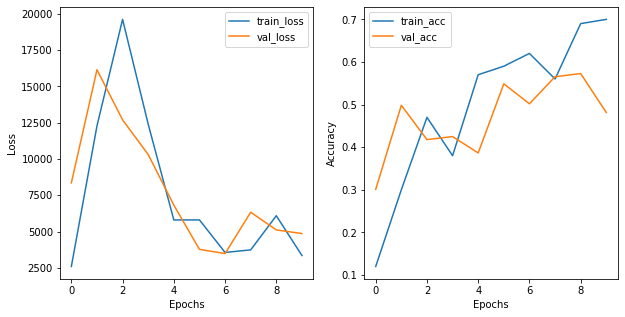

In [13]:
# plot the loss and accuracy curves
plot_loss_and_accuracy(train_losses, train_acc,val_losses,val_acc)

In [14]:
# test the model on the validation set
test_loss, test_accuracy = test_loss_and_accuracy(model, mnist_valset)
print("Test loss:",test_loss)
print("Test accuracy:",test_accuracy)

Test loss: 4862.645972277221
Test accuracy: 0.48125


## Tuning

In [15]:
# The next step is to find the optimal value for lambda, number of epochs, learning rate and batch size. 
# CHOSE ANY TWO from the above mentioned to tune.
# Create plot and table to show the effect of the hparams.

# initialize the model
model = Single_layer_classifier( 28*28, 10)

lr = [0.1,0.01,1e-3,1e-4]
lambda_ = [0,0.005,0.01]
num_epochs = 5

# create a dataframe to store the results
import pandas as pd
df = pd.DataFrame(columns = ["lr","lambda","epochs","val_loss","val_accuracy"])


for lr_ in lr:
    for reg_val in lambda_:
        print("lr:",lr_,"lambda:",reg_val,"epochs:",num_epochs, "\t--->" ,end = " ")
        # train the model
        train_losses, train_acc, val_losses, val_acc = train(model,mini_train_set,mnist_valset,epochs = num_epochs, batch_size = 64, lr = lr_, reg_coeff = reg_val, verbose = False)
        # test the model on the validation set
        val_loss, val_accuracy = test_loss_and_accuracy(model, mnist_valset)
        print("val_loss:",val_loss,"val_accuracy:",val_accuracy)
        df = df.append({"lr":lr_,"lambda":reg_val,"epochs":num_epochs,"val_loss":val_loss,"val_accuracy":val_accuracy},ignore_index=True)
        
    


lr: 0.1 lambda: 0 epochs: 5 	---> val_loss: 378406.0234815161 val_accuracy: 0.5584166666666667
lr: 0.1 lambda: 0.005 epochs: 5 	---> val_loss: 113388.20308307986 val_accuracy: 0.6938333333333333
lr: 0.1 lambda: 0.01 epochs: 5 	---> val_loss: 39345.056983425304 val_accuracy: 0.6938333333333333
lr: 0.01 lambda: 0 epochs: 5 	---> val_loss: 39345.056983425304 val_accuracy: 0.6938333333333333
lr: 0.01 lambda: 0.005 epochs: 5 	---> val_loss: 37421.11185664472 val_accuracy: 0.6938333333333333
lr: 0.01 lambda: 0.01 epochs: 5 	---> val_loss: 33841.62923054688 val_accuracy: 0.6938333333333333
lr: 0.001 lambda: 0 epochs: 5 	---> val_loss: 33841.62923054688 val_accuracy: 0.6938333333333333
lr: 0.001 lambda: 0.005 epochs: 5 	---> val_loss: 33672.79799230808 val_accuracy: 0.6938333333333333
lr: 0.001 lambda: 0.01 epochs: 5 	---> val_loss: 33337.56816012119 val_accuracy: 0.6938333333333333
lr: 0.0001 lambda: 0 epochs: 5 	---> val_loss: 33337.56816012119 val_accuracy: 0.6938333333333333
lr: 0.0001 lam

In [16]:
df

,lr,lambda,epochs,val_loss,val_accuracy
0,0.1000,0.000,5.0,378406.023482,0.558417
1,0.1000,0.005,5.0,113388.203083,0.693833
2,0.1000,0.010,5.0,39345.056983,0.693833
3,0.0100,0.000,5.0,39345.056983,0.693833
4,0.0100,0.005,5.0,37421.111857,0.693833
5,0.0100,0.010,5.0,33841.629231,0.693833
6,0.0010,0.000,5.0,33841.629231,0.693833
7,0.0010,0.005,5.0,33672.797992,0.693833
8,0.0010,0.010,5.0,33337.568160,0.693833
9,0.0001,0.000,5.0,33337.568160,0.693833


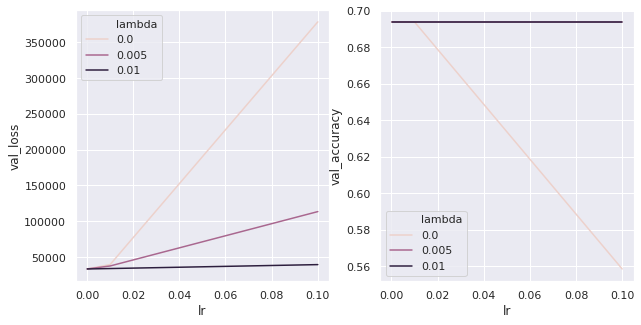

In [17]:
# make plots for the results
import seaborn as sns
sns.set()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.lineplot(x="lr", y="val_loss", hue="lambda", data=df, legend = 'full') 
plt.subplot(1,2,2)
sns.lineplot(x="lr", y="val_accuracy", hue="lambda", data=df, legend = 'full')
plt.show()


### final training

In [18]:
### Report final performance on MNIST test set
# from above we can see that the best value for lambda is 0.01 and the best value for lr is 0.001

# initialize the model
model = Single_layer_classifier( 28*28, 10)
# train the model
train_losses, train_acc, val_losses, val_acc = train(model,mnist_trainset,mnist_valset,\
                        epochs = 20, batch_size = 64, lr = 0.001, reg_coeff = 0.01, verbose = False)

# plot the loss and accuracy curves
# plot_loss_and_accuracy(train_losses, train_acc,val_losses,val_acc)


### Report final performance on mnist test set

In [19]:
# test on the test set
test_loss, test_accuracy = test_loss_and_accuracy(model, mnist_testset)
print("Test loss:",test_loss)
print("Test accuracy:",test_accuracy)


Test loss: 1003.3873654058586
Test accuracy: 0.8508


### Find the best performing class and the worst performing class

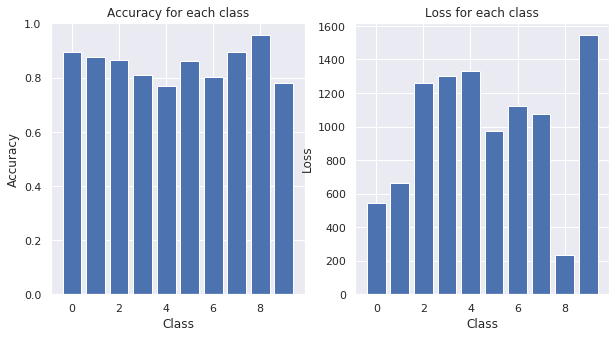

In [20]:
# best and worst performing classes on the test set

# seperate the test set into 10 classes
classes = [[] for i in range(10)]
for i in range(len(mnist_testset)):
    # class based on the label
    label = mnist_testset[i][1]
    classes[label].append(mnist_testset[i])
    

# test the model on each class
class_acc = []
class_loss = []
for i in range(10):
    test_loss, test_accuracy = test_loss_and_accuracy(model, classes[i])
    class_acc.append(test_accuracy)
    class_loss.append(test_loss)

# bar plot for the accuracy
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(range(10),class_acc)
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Accuracy for each class")

# bar plot for the loss
plt.subplot(1,2,2)
plt.bar(range(10),class_loss)
plt.xlabel("Class")
plt.ylabel("Loss")
plt.title("Loss for each class")
plt.show()




* best performing class : 9
* worst  performing class : 7

# Training a Linear Classifier on MNIST from scikit-learn



In this section you have to train a linear classifier from the scikit-learn library and compare its results against your implementation.
(https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [21]:
# Import the necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier


def dataset_to_arrays(dataset):
  """ flattens the images, and normalizes.
  """
  X = np.array( [np.array(x).flatten()/255 for x,y in dataset])
  Y = np.array( [np.array(y).flatten() for x,y in dataset])
  return X,Y

In [22]:
%%capture

# Define the classifier
classifier = OneVsRestClassifier(LogisticRegression())

X,y = dataset_to_arrays(mnist_trainset)
test_x, test_y = dataset_to_arrays(mnist_testset)

# Fit the model to the training data
classifier.fit(X,y)

# Make predictions on the test data
y_pred = classifier.predict(test_x)

In [23]:
# Calculate the accuracy
from sklearn.metrics import accuracy_score
print("Accuracy on the test set: %.2g" % accuracy_score(test_y, y_pred))

Accuracy on the test set: 0.92


### Compare the training and test accuracies for the your implementation and linear classifier from scikit-learn

* the linear classifier from sklearn doesn't learn on iterations. so it does not give train accuracy for each iteration.



In [24]:
# trainset 
print("sklearn linear model" )
print("--------------------")

for i,dataset in enumerate([mnist_trainset,mnist_valset,mnist_testset]):
  names = ["train", "val", "test"]
  X,y = dataset_to_arrays(dataset)
  y_pred = classifier.predict(X)
  print("Accuracy on the %s set: %.2g" % (names[i], accuracy_score(y, y_pred)))


print("\n my linear model" )
print("--------------------")

for i,dataset in enumerate([mnist_trainset,mnist_valset,mnist_testset]):
  names = ["train", "val", "test"]
  # use model 
  test_loss, test_accuracy = test_loss_and_accuracy(model, dataset)
  print("Accuracy on the %s set: %.2g" % (names[i], test_accuracy))

sklearn linear model
--------------------
Accuracy on the train set: 0.93
Accuracy on the val set: 0.92
Accuracy on the test set: 0.92

 my linear model
--------------------
Accuracy on the train set: 0.85
Accuracy on the val set: 0.85
Accuracy on the test set: 0.85


### Any additional observations / comments?

## BONUS Question
### Observe the effect on test set accuracy by changing the number of training samples.
### Train on 10%, 20% and 50% training data and plot the percentage of training data v.s. the test accuracy.  

In [25]:
# train on 10%,20%,50% of the training set and test on the test set
for percent in [0.1,0.2,0.5]:
  print("Training on %d%% of the training set" % (percent*100))
  # get the training set
  train_set = mnist_trainset[:int(len(mnist_trainset)*percent)]
  # initialize the model
  model = Single_layer_classifier( 28*28, 10)
  # train the model
  train_losses, train_acc, val_losses, val_acc = train(model,train_set,None,\
                          epochs = 20, batch_size = 64, lr = 0.001, reg_coeff = 0.01, verbose = False)
  # test on the test set
  test_loss, test_accuracy = test_loss_and_accuracy(model, mnist_testset)
  print("Test loss:",test_loss)
  print("Test accuracy:",test_accuracy)
  print("")

Training on 10% of the training set
Test loss: 955.2665598715907
Test accuracy: 0.8687

Training on 20% of the training set
Test loss: 970.3732014170986
Test accuracy: 0.8637

Training on 50% of the training set
Test loss: 809.0257723878053
Test accuracy: 0.8719



# Question 2

## Implementing Backpropagation

Now that you have had some experience with single layer networks, we can proceed to more complex architectures. But first we need to completely understand and implement backpropagation.

## Backpropagation:

Simply put, a way of computing gradients of expressions through repeated application of chain rule. If
$$
L = f (g (h (\textbf{x})))
$$
then, by the chain rule we have:
$$
\frac{\partial L}{\partial \textbf{x}} = \frac{\partial f}{\partial g} \cdot \frac{\partial g}{\partial h} \cdot \frac{\partial h}{\partial \textbf{x}} 
$$

** Look into the class Lecture for more detail **



## Question 2 : Scalar Backpropagation

Evaluate the gradient of the following function w.r.t. the input:

$$ f(x,y,z) =  log(\sigma(\frac{cos(\pi \times x)+sin(\pi \times y/2)}{tanh(z^2)}))$$
where $\sigma$ is the sigmoid function. Find gradient for the following inputs:
  * $(x,y,z)$ =  (2,4,1)
  * $(x,y,z)$ =  (9,14,3)
  * $(x,y,z)$ =  (128,42,666)
  * $(x,y,z)$ =  (52,14,28)

      

*Main idea* : 
1.    make graph 
2.    forward should give a number
3.    backward should take upstream grad
4.    seperate class for each function




## define classes

In [26]:
import numpy as np

class Scalar :
  def __init__(self, value):
    self.value = value
    self.grad = 0
  def forward(self):
    return self.value
  def backward(self,upstream_grad):
    self.grad = upstream_grad
  def __repr__(self):
    """For printing.
      only two decimal places"""
    return "%.2f" % self.value 

class Mult:
  def __init__(self,a,x):
    self.a = a
    self.x = x
  def forward(self):
    return self.a.forward() * self.x.forward()
  def backward(self, upstream_grad):
    self.a.backward(upstream_grad * self.x.forward())
    self.x.backward(upstream_grad * self.a.forward())
  def __repr__(self):
    return "%s*%s" % (self.a, self.x)

class Add:
  def __init__(self,a,b):
    self.a = a
    self.b = b
  def forward(self):
    return self.a.forward() + self.b.forward()
  def backward(self, upstream_grad):
    self.a.backward(upstream_grad)
    self.b.backward(upstream_grad)
  def __repr__(self):
    return "%s + %s" % (self.a, self.b)

class div:
  def __init__(self,a,b):
    self.a = a
    self.b = b
  def forward(self):
    return self.a.forward() / self.b.forward()
  def backward(self, upstream_grad):
    self.a.backward(upstream_grad / self.b.forward())
    self.b.backward(- upstream_grad * self.a.forward() / (self.b.forward() ** 2)) 
  def __repr__(self):
    return "{%s}/{%s}" % (self.a, self.b)

class Square:
  def __init__(self,x):
    self.x = x
  def forward(self):
    return self.x.forward() ** 2
  def backward(self, upstream_grad):
    self.x.backward(2 * self.x.forward() * upstream_grad)
  def __repr__(self):
    return "(%s)^2" % self.x

class Sigmoid:
  def __init__(self,x):
    self.x = x
  def forward(self):
    return 1 / (1 + np.exp(-self.x.forward()))
  def backward(self, upstream_grad):
    self.x.backward(upstream_grad * (1 - self.forward()) * self.forward())
  def __repr__(self):
    return "σ(%s)" % self.x
    

class Tanh:
  def __init__(self,x):
    self.x = x
  def forward(self):
    return np.tanh(self.x.forward())
  def backward(self, upstream_grad):
    self.x.backward(upstream_grad * (1 - self.forward() ** 2))
  def __repr__(self):
    return "Tanh(%s)" % self.x
  
class sin:
  def __init__(self,x):
    self.x = x
  def forward(self):
    return np.sin(self.x.forward())
  def backward(self, upstream_grad):
    self.x.backward(upstream_grad * np.cos(self.x.forward()))
  def __repr__(self):
    return "sin(%s)" % self.x
  
class cos:
  def __init__(self,x):
    self.x = x
  def forward(self):
    return np.cos(self.x.forward())
  def backward(self, upstream_grad):
    self.x.backward(- upstream_grad * np.sin(self.x.forward()))
  def __repr__(self):
    return "cos(%s)" % self.x

class log:
  def __init__(self,x):
    self.x = x
  def forward(self):
    return np.log(self.x.forward())
  def backward(self, upstream_grad):
    self.x.backward(upstream_grad / self.x.forward())
  def __repr__(self):
    return "log(%s)" % self.x

  

In [27]:
# Now write the class func
# which constructs the graph (all operators), forward and backward functions.

class Func:
    def __init__(self):
        pass
                   
    def forward(self,x,y,z):
      """x,y,z are the input variables and float values not Scalar objects
      """
      # input variables
      self.x = Scalar(x)
      self.y = Scalar(y)
      self.z = Scalar(z)

      # constants
      pi = Scalar(np.pi)
      half_pi = Scalar(np.pi/2)
      
      # function graph
      a = cos(Mult(pi,self.x))
      b = sin(Mult(half_pi,self.y))
      c = Tanh(Square(self.z))
      d = div(Add(a,b),c)
      e = Sigmoid(d)
      f = log(e)

      self.f = f
      print(f)
      
      # forward pass
      return self.f.forward()
        
    
    def backward(self):
        # backward pass
        self.f.backward(1)
        grad_x = self.x.grad
        grad_y = self.y.grad
        grad_z = self.z.grad

        return [grad_x,grad_y,grad_z]
    

## testing

In [28]:
def test(x,y,z):
    f = Func()
    print("f(%.5g,%.5g,%.5g) = %.5g" % (x,y,z,f.forward(x,y,z)))
    print("df/dx = %.5g" % f.backward()[0])
    print("df/dy = %.5g" % f.backward()[1])
    print("df/dz = %.5g" % f.backward()[2])
    print()


test(2,4,1)
test(9,14,3)
test(128,42,666)
test(52,14,28)




log(σ({cos(3.14*2.00) + sin(1.57*4.00)}/{Tanh((1.00)^2)}))
f(2,4,1) = -0.23823
df/dx = 2.1417e-16
df/dy = 0.43721
df/dz = -0.30697

log(σ({cos(3.14*9.00) + sin(1.57*14.00)}/{Tanh((3.00)^2)}))
f(9,14,3) = -1.3133
df/dx = -2.5314e-15
df/dy = -1.1483
df/dz = 2.6722e-07

log(σ({cos(3.14*128.00) + sin(1.57*42.00)}/{Tanh((666.00)^2)}))
f(128,42,666) = -0.31326
df/dx = 1.3244e-14
df/dy = -0.42245
df/dz = -0

log(σ({cos(3.14*52.00) + sin(1.57*14.00)}/{Tanh((28.00)^2)}))
f(52,14,28) = -0.31326
df/dx = -6.6263e-15
df/dy = -0.42245
df/dz = -0



# Question 3 : Modular Vector Backpropagation


* Construct a Linear Layer module, implementing the forward and backward functions for arbitrary sizes.
* Construct a ReLU module, implementing the forward and backward functions for arbitrary sizes.
* Create a 2 layer MLP using the constructed modules.

* Modifying the functions built in Question 1 , train this two layer MLP for the same data set, MNIST, with the same train-val split.

## define classes

In [29]:
# Class for Linear Layer (If you're stuck, you can refer to code of PyTorch/Tensorflow packages) 

class Linear:
    """ this works for batch input 
    it has bais also
    input is batch of inputs not one image"""

    def __init__(self, input_size, output_size,SIGMA = 10**(-3)):
        self.input_size = input_size
        self.output_size = output_size

        # self.W = np.random.randn(input_size, output_size) 
        # normal distribution with mean 0 and std  = 10^(-3)
        
        self.W = np.random.normal(0, SIGMA, (input_size, output_size))
        self.b = np.zeros(output_size)

        self.grad_W = np.zeros((input_size, output_size))
        self.grad_b = np.zeros(output_size)
        
        
    def forward(self, x):
        self.x = x
        self.y = np.dot(x, self.W) + self.b
        return self.y
    
    def backward(self, grad_y):
        """ grad_y is the gradient of the loss w.r.t. the output of the layer for a batch of inputs 
        
            so grad_y has shape (batch_size, output_size)
        """
        self.grad_W = self.x.T @ grad_y             # this is sum of all the gradients of the loss w.r.t. the output of the layer for a batch of inputs
        self.grad_b = np.sum(grad_y, axis=0)
        grad_x = np.dot(grad_y, self.W.T)
        return grad_x
    
    def step(self, learning_rate):
        self.W -= learning_rate * self.grad_W
        self.b -= learning_rate * self.grad_b                                   # check: how it  changes with zero centring the images 

In [30]:
# Class for ReLU
class ReLU:
    def __init__(self):
        pass
    
    def forward(self, x):
        self.x = x
        self.y = np.maximum(0, x)
        return self.y
    
    def backward(self, grad_y):
        """ grad_y is the gradient of the loss w.r.t. the output of the layer for a batch of inputs 
            so grad_y has shape (batch_size, output_size)
        """
        grad_x = grad_y * (self.x > 0)
        return grad_x


In [31]:
# Your 2 layer MLP 
class MLP:
    """ input_size is the size of the flattened image
    x : batch of images
    image is flattened in forward pass

    
    """
    
    def __init__(self, input_size, hidden_size, output_size):
        self.linear1 = Linear(input_size, hidden_size)
        self.relu = ReLU()
        self.linear2 = Linear(hidden_size, output_size)
        
    def forward(self, x):
        #flatten the image
        x = x.reshape(x.shape[0], -1)
        #normalize the image
        x = x/255 
        
        x = self.linear1.forward(x)
        x = self.relu.forward(x)
        x = self.linear2.forward(x)
        return x
    
    def backward(self, grad_y):
        """ grad_y is the gradient of the loss w.r.t. the output of the layer (i.e scores) for a batch of inputs 
            so grad_y has shape (batch_size, output_size)
        """
        grad_x = self.linear2.backward(grad_y)
        grad_x = self.relu.backward(grad_x)
        grad_x = self.linear1.backward(grad_x)
        return grad_x
    
    def step(self, learning_rate):
        self.linear1.step(learning_rate)
        self.linear2.step(learning_rate)
        
    def parameters(self):
        return [self.linear1.W, self.linear1.b, self.linear2.W, self.linear2.b]
    
    def gradients(self):
        return [self.linear1.grad_W, self.linear1.grad_b, self.linear2.grad_W, self.linear2.grad_b]


In [32]:
# softmax class for the loss function
class Softmax_loss:
    def __init__(self):
        pass
    def forward(self,scores,y_labels):
        """ scores shape : (batch_size, output_size)
            y_labels shape : (batch_size, )


            return loss
            loss is mean of the loss for each batch. so keep the count of the number of batches. finally, divide the loss by it.
            loss shape : (1, )
        """
        self.scores = scores
        self.y_labels = y_labels

        # subtract max for numerical stability
        scores -= np.max(scores, axis=1, keepdims=True)


        first_term = -scores[range(len(y_labels)), y_labels]
        second_term = np.log(np.sum(np.exp(scores), axis=1))
        loss = first_term + second_term

        return np.mean(loss)

    def backward(self):
        """ return grad_scores
            grad_scores shape : (batch_size, output_size)
        """
        scores = self.scores.copy()
        # subtract max for numerical stability
        scores -= np.max(self.scores, axis=1, keepdims=True) 
        # fix the error


        grad_scores = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)
        grad_scores[range(len(self.y_labels)), self.y_labels] -= 1
        return grad_scores

    

## utils for batched data

In [33]:
def accuracy(scores, y_labels):
    """ scores shape : (batch_size, output_size)
        y_labels shape : (batch_size, )

        return corrects, total
    """
    predictions = np.argmax(scores, axis=1)
    corrects = np.sum(predictions == y_labels)
    total = len(y_labels)
    return corrects, total

In [34]:
 from tqdm import tqdm

def train(model, train_set, N_EPOCHS= 10 , BATCH_SIZE=16, LEARNING_RATE=0.001,testing = False,print_to_console = True):
  """ 
  dataset : list of tuples (x,y) where x is the image and y is the label
  model: model.forward(batch_x) => batch_scores

  loss = softmax_loss

  Return:
  training_loss , training_accuracy : lists
  ----------------
  for testing or validation : set testing = True
  """

  if testing:
    N_EPOCHS = 1
    

  loss_fn = Softmax_loss()


  # store loss and accuracy
  train_loss = []
  train_acc = []

  # Train for t epochs:
  for epoch in tqdm(range(N_EPOCHS)):
      if print_to_console:
        print("Epoch: ",epoch)

      

      #metrics
      epoch_loss = 0
      batch_count = 0

      epoch_corrects = 0
      epoch_total = 0


    
      generator = get_minibatch(train_set, batch_size= BATCH_SIZE)
      
      for mini_batch in generator:

        X = np.array([np.array(x) for x,y in mini_batch])
        Y = np.array([y for x,y in mini_batch])

        # Forward pass
        scores = model.forward(X)
        batch_mean_loss = loss_fn.forward(scores,Y)
        batch_mean_acc = accuracy(scores,Y)

        # update metrics
        epoch_loss += batch_mean_loss
        epoch_corrects += batch_mean_acc[0]
        epoch_total += batch_mean_acc[1]

        batch_count += 1

        if not testing:
          # Backward pass
          grad_scores = loss_fn.backward()
          model.backward(grad_scores)
          
          # Update parameters
          model.step(LEARNING_RATE)

      # update metrics for epoch
      epoch_loss /= batch_count
      epoch_acc = epoch_corrects / epoch_total

      # store metrics
      train_loss.append(epoch_loss)
      train_acc.append(epoch_acc)

      if print_to_console:
        print( f"loss: {epoch_loss:.4f}  acc: {epoch_acc:.4f}" )

  return train_loss, train_acc



## sanity check

In [35]:
%%capture
#  overfit to a small dataset
size = 500        # got 99.55 with 50 epochs
mini_train_set = mnist_trainset[:size]


model = MLP(784, 100, 10)
train_loss, train_acc = train(model, mini_train_set, N_EPOCHS=20, BATCH_SIZE=100, LEARNING_RATE=0.01, testing = False, print_to_console = True)

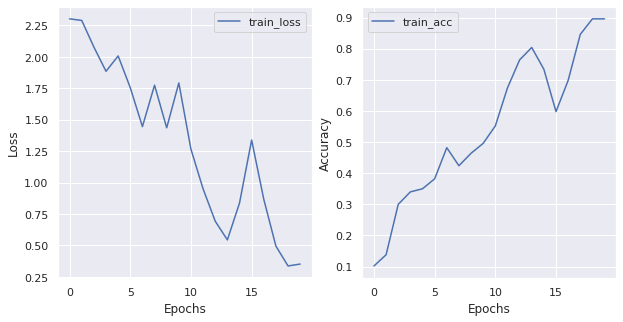

In [36]:
plot_loss_and_accuracy(train_loss, train_acc)

## model Training

In [ ]:
%%capture
model = MLP(28*28, 100, 10)
train_loss, train_acc = train(model, mnist_trainset, N_EPOCHS= 10 , BATCH_SIZE=16, LEARNING_RATE=0.01,testing = False,print_to_console = True)

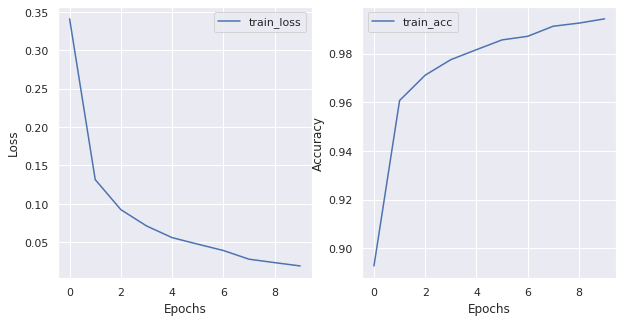

In [38]:
plot_loss_and_accuracy(train_loss, train_acc)

In [39]:
# Find the accuracy on the validation set

val_loss, val_acc = train(model, mnist_valset, N_EPOCHS= 1 , BATCH_SIZE=16, LEARNING_RATE=0.01,testing = True,print_to_console = True)

100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

Epoch:  0
loss: 0.0964  acc: 0.9732


In [ ]:
# Find the optimal value of learning rate and batch size. 
# Use the same tuning strategy as the previous question
# Create plot and table to show the effect of the hparams.

learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64, 128]

# store the results in pandas dataframe
df = pd.DataFrame(columns = ["learning_rate", "batch_size", "train_loss", "train_acc", "val_loss", "val_acc"])

for lr in learning_rates:
    for bs in batch_sizes:
        model = MLP(28*28, 100, 10)
        train_loss, train_acc = train(model, mnist_trainset, N_EPOCHS= 10 , BATCH_SIZE=bs, LEARNING_RATE=lr,testing = False,print_to_console = False)
        val_loss, val_acc = train(model, mnist_valset, N_EPOCHS= 1 , BATCH_SIZE=bs, LEARNING_RATE=lr,testing = True,print_to_console = False)

        df = df.append({"learning_rate": lr, "batch_size": bs, "train_loss": train_loss[-1], "train_acc": train_acc[-1], "val_loss": val_loss[-1], "val_acc": val_acc[-1]}, ignore_index=True)

    

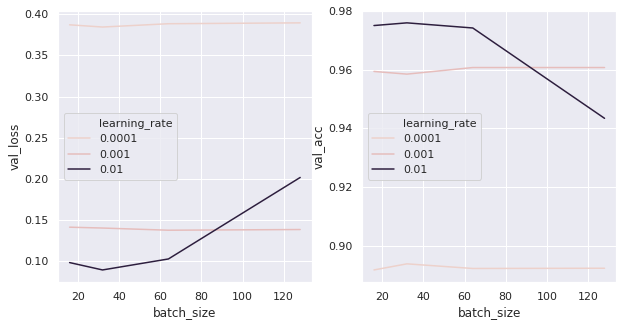

In [41]:
# make plots for the results
import seaborn as sns
sns.set()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
# sns.lineplot(x="lr", y="val_loss", hue="lambda", data=df, legend = 'full') 
sns.lineplot(x="batch_size", y="val_loss", hue="learning_rate", data=df, legend = 'full')
plt.subplot(1,2,2)
# sns.lineplot(x="lr", y="val_accuracy", hue="lambda", data=df, legend = 'full')
sns.lineplot(x="batch_size", y="val_acc", hue="learning_rate", data=df, legend = 'full')
plt.show()


final performance on mnist test set

In [42]:
### Report final performance on MNIST test set
# best hprams : lr = 0.01, bs = 64

model = MLP(28*28, 100, 10)
train_loss, train_acc = train(model, mnist_trainset, N_EPOCHS= 10 , BATCH_SIZE=64, LEARNING_RATE=0.01,testing = False,print_to_console = False)
test_loss, test_acc = train(model, list(mnist_testset), N_EPOCHS= 1 , BATCH_SIZE=64, LEARNING_RATE=0.01,testing = True,print_to_console = False)

print( f"test loss: {test_loss[-1]:.4f}  test acc: {test_acc[-1]:.4f}" )



100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

test loss: 0.0836  test acc: 0.9767


### Find the best performing class and the worst performing class

100%|██████████| 1/1 [00:00<00:00, 54.87it/s]


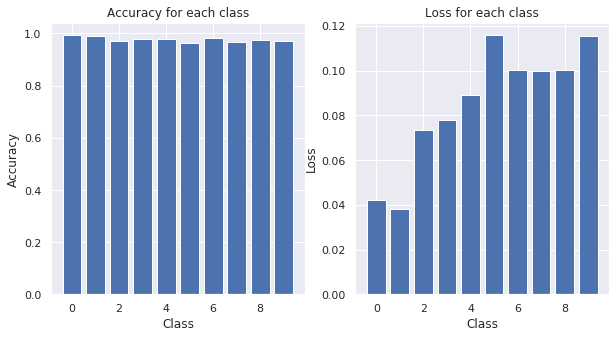

In [43]:
# class wise performance

# best and worst performing classes on the test set

# seperate the test set into 10 classes
classes = [[] for i in range(10)]
for i in range(len(mnist_testset)):
    # class based on the label
    label = mnist_testset[i][1]
    classes[label].append(mnist_testset[i])
    

# test the model on each class
class_acc = []
class_loss = []
for i in range(10):
    test_loss, test_accuracy = train(model, classes[i] ,testing = True,print_to_console = False)
    class_acc.append(test_accuracy[0] )
    class_loss.append(test_loss[0] )

# bar plot for the accuracy
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(range(10),class_acc)
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.title("Accuracy for each class")

# bar plot for the loss
plt.subplot(1,2,2)
plt.bar(range(10),class_loss)
plt.xlabel("Class")
plt.ylabel("Loss")
plt.title("Loss for each class")
plt.show()




* best performing class: 0
* worst perming class : 9

### Any additional observations / comments?

### OBSERVATION:  
* without normalising the image ( divide by 255), the accuracy is not going above 20. 
* with very large batch size, it is always outputting one single prediction for all images. but at different runs that prediction is different.
* it may be stuck at local minima

## BONUS Question
### Observe the effect on test set accuracy by changing the number of training samples.
### Train on 10%, 20% and 50% training data and plot the percentage of training data v.s. the test accuracy.  

In [44]:
# WRITE CODE HERE
# import time 

# train on 10%,20%,50% of the training set and test on the test set
for percent in [0.1,0.2,0.5]:

    print("Training on %d%% of the training set" % (percent*100))
    # time.sleep(0.1)
    size = int(len(mnist_trainset)*percent)
    mini_train_set = mnist_trainset[:size]  
    model = MLP(28*28, 100, 10)
    train_loss, train_acc = train(model, mini_train_set, N_EPOCHS= 10 , BATCH_SIZE=64, LEARNING_RATE=0.01,testing = False,print_to_console = False)
    test_loss, test_acc = train(model, list(mnist_testset), N_EPOCHS= 1 , BATCH_SIZE=64, LEARNING_RATE=0.01,testing = True,print_to_console = False)
    print( f"test loss: {test_loss[-1]:.4f}  test acc: {test_acc[-1]:.4f}" )
    print("")


 20%|██        | 2/10 [00:00<00:00, 11.57it/s]

Training on 10% of the training set


 10%|█         | 1/10 [00:00<00:01,  5.83it/s]

test loss: 0.2026  test acc: 0.9425

Training on 20% of the training set


  0%|          | 0/10 [00:00<?, ?it/s]

test loss: 0.1494  test acc: 0.9574

Training on 50% of the training set


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

test loss: 0.1162  test acc: 0.9693



Accuracy increasing with increasing training dataset size

# Question 4


## Implementing a Convolution Module with Numpy

* This topic will require you to implement the Convolution operation using Numpy.
* We will use the Module for tasks like Blurring.
* Finally, we implement Backpropagation for the convolution module.




* Implement a naive Convolution module, with basic functionalities: kernel_size, padding, stride and dilation
  
* Test out the convolution layer by using it to do gaussian blurring on 10 random images of CIFAR-10 dataset


### shape checks etc.

reference for size of output :(dialation): https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [45]:
# a of shape (32,3,5,5) 
# b of shape (10,3,5,5)
a = np.random.randn(32,3,5,5)
print(a.shape)
# make extra dimension at dim 1 in a
a = np.expand_dims(a,1)
print(a.shape)
b = np.random.randn(10,3,5,5)

c = a*b
print(c.shape)

# sum last 3 dimensions in c 
d = np.sum(c,axis = (2,3,4))
d.shape

(32, 3, 5, 5)
(32, 1, 3, 5, 5)
(32, 10, 3, 5, 5)


(32, 10)

### conv class

In [46]:
## Define a class Convolution Layer, which is initialized with the various required params:
class Convolution_Layer():
    
    def __init__(self,in_channels,out_channels , filter_size, bias=False, stride=1, padding = 0, dilation=1):
        """
        filter_size : int    : square filter
        padding, stride, dilation : int : same for both height and width
        """
        # For an untrained layer, set random initial filter weights
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.filter_size = filter_size
        self.bias_enabled = bias
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        # Initialize weights
        self.weights = np.random.randn(out_channels, in_channels, filter_size, filter_size)
        self.bias = np.random.randn(out_channels) if bias else None


    def forward(self,input_batch, check_output_shape = False):
        """ main idea for vectorizable implementation:
        use views;

        psuedo code:
        ----------------
        for one output pixel:
            get input patch  (B,in_C,k,k)
            expand dim= 1   (B,1,in_C,k,k)
            multiply (element vise) with kernal    (B,out_C,in_C,k,k)
            sum over in_C and k and k   (B,out_C)
            add bias (if enabled)   (B,out_C)
        ----------------
              

        """

        # Input Proprocess(According to pad etc.) Input will be of size (Batch_size, in_channels, inp_height, inp_width)
        input_batch = np.pad(input_batch, ((0,0), (0,0), (self.padding, self.padding), (self.padding, self.padding)), 'constant', constant_values=0)
        # normalize input
        input_batch = input_batch / 255.0
        # Reminder: Save Input for backward-prop
        self.input_batch = input_batch
        # since, the padding already applied to the input, removing it from the formula

        # print("input_batch shape" , input_batch.shape)
        h_out = (input_batch.shape[2] +  - self.dilation * (self.filter_size - 1) - 1) // self.stride + 1
        w_out = (input_batch.shape[3] +  - self.dilation * (self.filter_size - 1) - 1) // self.stride + 1

        self.h_out = h_out
        self.w_out = w_out



        # Check if output shape is correct
        # if check_output_shape:
        #     print("h_out: ", h_out)
        #     print("w_out: ", w_out)
            # return None
        
        output = np.zeros((input_batch.shape[0], self.out_channels, h_out, w_out))

        # making storage
        #-----------------------------------------------------
        # _shape = ( *output.shape, *self.weights.shape)

        # self.storage_for_backward = np.zeros(_shape)
        #-----------------------------------------------------


        s = self.stride
        k = self.filter_size
        d = self.dilation


        # Vectorized Conv operation:
        for i in range(h_out):
            for j in range(w_out):
                # get input patch  (B,in_C,k,k)
                input_patch = input_batch[:, :, i*s : i*s + k*d : d ,  j*s : j*s + k*d : d]
                # expand dim= 1   (B,1,in_C,k,k)
                input_patch = np.expand_dims(input_patch, 1)
                
                # check input_patch shape if it is not (B,1,in_C,k,k) then continue
                # if input_patch.shape != (input_batch.shape[0],1,input_batch.shape[1],k,k):
                #     print("input_patch_size mismatch")
                #     print("input_patch_size:",input_patch.shape)
                #     print("i,j:",i,j)
                #     continue

                # multiply (element vise) with kernal    (B,out_C,in_C,k,k)
                output[:, :, i, j] = np.sum(input_patch * self.weights, axis=(2,3,4))

                # -----------------------------------------------------
                # # sum the input patch for dim 0 
                # # store it in storage
                # # self.storage_for_backward[:, :, i, j] = np.sum(input_patch, axis=0)                                                         # leave dim1, check if it broadcasts in backward 
                # temp = np.sum(input_patch, axis=0)                                                         # leave dim1, check if it broadcasts in backward
                # #repeat in dim1 to match the shape of output channels
                # temp = np.repeat(temp, self.out_channels, axis=0)
                # # print(temp.shape)
                # self.storage_for_backward[:, :, i, j] = temp
                # -----------------------------------------------------


                # sum over in_C and k and k   (B,out_C)
                # add bias (if enabled)   (B,out_C)

                if self.bias_enabled:
                    output[:, :, i, j] += self.bias


        # if check_output_shape:
        #     print("output_size:",output.shape)
            
        # Output will be of the size (Batch_size, out_channels, out_height, out_width)
        return output

    
    def backward(self, grad_of_output_size):


        
        """
                    
        ***************************** Speed is  "A CONSERN" ************************

        grad_of_output_size : (B, out_C, out_H, out_W)
        main idea:
        ----------------
        for each output pixel:
            store corresponding input patch { that is converted to shape of kernel  by summing over broadcasted dimensions }: in forward * operation.   

            {:: check rough work 4th paper
            mearge --> B
            make copies --> out_C
            }



        finally multiply (*) with grad_of_output_size (by broadcasting)
        sum over the dimensions without broadcasting ( = summing all branches )                                             # this is creating out of memory error
                                                                                                                            so loop over kernel size

            finally, we get patch size = kernel size; 

        so,storage size = (output_size , input_patch_size)
        ----------------
        """

        # normalize the grad_of_output_size
        grad_of_output_size = grad_of_output_size / np.max(grad_of_output_size)


        h_out = self.h_out
        w_out = self.w_out
        input_batch = self.input_batch

        s = self.stride
        k = self.filter_size
        d = self.dilation

        # intialize grad_kernel with all zeros 
        grad_kernel = np.zeros(self.weights.shape)


        for i in range(h_out):
            for j in range(w_out):
                # get input patch  (B,in_C,k,k)
                input_patch = input_batch[:, :, i*s : i*s + k*d : d ,  j*s : j*s + k*d : d].copy()
                # expand dim= 1   (B,1,in_C,k,k)
                input_patch = np.expand_dims(input_patch, 1)

                grad_patch = grad_of_output_size[:, :, i, j].copy()
                grad_patch = np.expand_dims(grad_patch, 2)

                temp_shape = grad_patch.shape
                # add 2 extra dimensions to grad_patch
                grad_patch = grad_patch.reshape( *temp_shape, 1, 1)

                grad_kernel += np.sum(input_patch * grad_patch, axis=0)
        
        grad_kernel =  grad_kernel / np.max(grad_kernel)

        self.grad_weights = grad_kernel
        return grad_kernel
                
                # check input_patch shape if it is not (B,1,in_C,k,k) then continue
                # if input_patch.shape != (input_batch.shape[0],1,input_batch.shape[1],k,k):
                #     print("input_patch_size mismatch")
                #     print("input_patch_size:",input_patch.shape)
                #     print("i,j:",i,j)
                #     continue

                # multiply (element vise) with kernal    (B,out_C,in_C,k,k)
                # output[:, :, i, j] = np.sum(input_patch * self.weights, axis=(2,3,4))


        

        # storage = self.storage_for_backward
        # print("storage shape", storage.shape)
        # make extra 4 dimensions to match the shape of grad_of_output_size
        # old_shape = storage.shape
        # new_shape = ( *old_shape, 1,1,1,1)
        # storage = np.reshape(storage, new_shape)
        # grad = grad_of_output_size * storage

        # sum over the dimensions without broadcasting ( = summing all branches )
        # grad = np.sum(grad, axis=(0,1,2,3))                                                                                     #  out of memory error
        # print("grad shape", grad.shape)

        # -----------------------------------------------------

        # grad = np.zeros_like(self.weights )
        # q = grad_of_output_size.shape 
        # # for each ouput pixel
        # for i in range(q[0]):
        #     for j in range(q[1]):
        #         for k in range(q[2]):
        #             for l in range(q[3]):
        #                 storage[i,j,k,l] *= grad_of_output_size[i,j,k,l]                                            # check paper 5. before stating agian { loop over theta_1. then, sum over theta_1}
        
        


        # grad = np.sum(storage, axis=(0,1,2,3))                                                                                    

        


        # Hint: gradients from each independant operation can be summed




        
        #  return gradient of the size of the weight kernel
        # self.grad_weights = grad
        # self.grad_bias = np.sum(grad_of_output_size, axis=(0,2,3))

        # return grad
    def step(self, learning_rate):
        """ update the weights using the gradient and the learning rate
        then, make the gradient zero
        """
        # Update the weights using the gradient and the learning rate
        
        # normalize the gradient by dividing by max value
        self.grad_weights /= np.max(self.grad_weights) * np.max(self.weights)
        # update weights
        self.weights -= learning_rate * self.grad_weights  
        # make gradient zero
        self.grad_weights = np.zeros_like(self.weights)

        if self.bias_enabled:
            self.grad_bias /= np.max(self.grad_bias)
            self.bias -= learning_rate * self.grad_bias
            self.grad_bias = np.zeros_like(self.bias)



    
    def set_weights(self, new_weights):
        """ kernal shape : (out_channels, in_channels, filter_size, filter_size) 
        bais shape : (out_channels)
                
        """
        kernal, bias = new_weights
        self.weights = kernal
        self.bias = bias


        ## Replace the set of weights with the given 'new_weights'
        ## use this for setting weights for blurring, bilateral filtering etc.

### sanity check


In [47]:
### Download CIFAR-10 images and load it in a numpy array (https://www.cs.toronto.edu/~kriz/cifar.html)

# load cifa-10 dataset from torch 
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=None)
testset = datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=None)              
# convert to numpy array
train_data = np.array(trainset.data)
test_data = np.array(testset.data)

train_data.shape, test_data.shape



Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), (10000, 32, 32, 3))

### Initialize a conv layer. Set weights for gaussian blurring (do not train the filter for this part). Visualise the filters using matplotlib


 kernal shape  (3, 3, 3, 3)


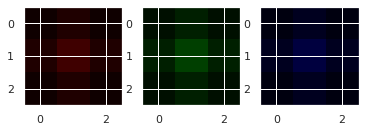

In [49]:
# kernal should blur each color channel seperately
grey_kernal = np.array([[1,2,1],[2,4,2],[1,2,1]])/ 16

kernel = np.zeros((3,3,3,3))
kernel[0,0] = grey_kernal
kernel[1,1] = grey_kernal
kernel[2,2] = grey_kernal



# kernel = kernel/np.sum(kernel)
print(" kernal shape " ,kernel.shape)

# using subplots
fig, ax = plt.subplots(1,3)
for i in range(3):
    ax[i].imshow(kernel[i].transpose(1,2,0))
plt.show()


### test on images

In [50]:
# 10 images from train_data
size = 10
mini_data = train_data[:size]
# change color channel to first
mini_data = np.transpose(mini_data, (0,3,1,2))
print("mini_data shape", mini_data.shape)
# channel first

mini_data shape (10, 3, 32, 32)


In [51]:
# conv_model = (in_channels=3, out_channels=3, filter_size=3, stride=1, padding=1, dilation=1, bias_enabled=True)
conv_model = Convolution_Layer(in_channels=3, out_channels=3, filter_size=3, stride=1, padding=1, dilation=1, bias=True)
conv_model.weights = kernel
conv_model.bias = np.zeros(3)

blurred_images = conv_model.forward(mini_data)

# delete the model
del conv_model

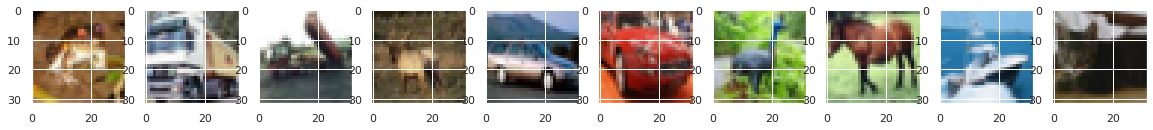

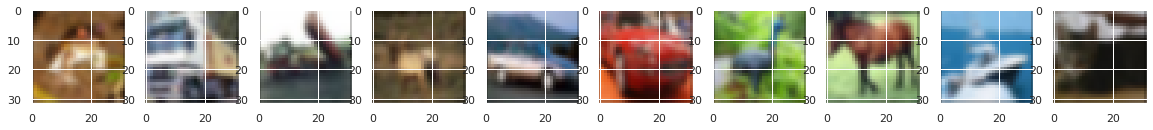

In [52]:
def show_blurring_effect(original_images, blurred_images,size):

    # set fig size 
    plt.figure(figsize=(20,10))
    # show original images
    for i in range(size):
        plt.subplot(2,size,i+1)
        plt.imshow(np.transpose(original_images[i], (1,2,0)))
    plt.show()

    plt.figure(figsize=(20,10))
    # show blurred images
    for i in range(size):
        plt.subplot(2,size,i+1+size)
        plt.imshow(np.transpose(blurred_images[i], (1,2,0)))
    plt.show()

show_blurring_effect(mini_data, blurred_images,size)

# Question 5


<br>
Now we will use this module for training a simple Convolution Layer using CIFAR-10 images. 

* The goal is to learn a set of weights, by using the backpropagation function created. To test the backpropagation, instead of training a whole network, we will train only a single layer.
  * Instantiate a Convolution  layer $C_0$ with 20 filters, each with size 5$\times$5 (RGB image, so 3 input channels). Load the given numpy array of size (20,3,5,5), which represents the weights of a convolution layer. Set the given values as the filter weights for $C_0$. Take 100 CIFAR-10 images. Save the output of these 100 images generated from this Convolution layer $C_0$. 
  
  * Now, initialize a new convolution layer $C$ with weight values sampled from uniform distribution [-1,1]. Use the $L_2$ loss between the output of this layer $C$ and the output generated in the previous step to learn the filter weights of $C_0$.


In [53]:
## Load filter weights from given numpy array "C0_weights.npy".
filter_weights = np.load("C0_weights.npy")


BATCH_SIZE = 20
N_BATCHES = 5


C_0 = Convolution_Layer(in_channels=3, out_channels=20, filter_size=5, stride=1, padding=2, dilation=1, bias=True)
C_0.set_weights((filter_weights, np.zeros(20)))

def cifar_batch_generator(batch_size=BATCH_SIZE, n_batches=N_BATCHES):
    for i in range(n_batches):
        mini_data =  train_data[i*batch_size:(i+1)*batch_size]
        mini_data = np.transpose(mini_data, (0,3,1,2))
        yield mini_data



In [54]:
output_C0 = []
generator = cifar_batch_generator()
for i in range(N_BATCHES):
    batch = next(generator)
    output_C0.append(C_0.forward(batch))

del C_0

In [55]:
# for part 2 we need to write a class for the  L2 loss
class L2_loss():
    def ___init__(self):
        pass
    
    def forward(self, C0_output,C_output):
        # Conv. output is of dimension (batchsize,channels,height,width)
        # calculate the L2 norm of (C0_output - C_output)
        loss = np.sum((C0_output - C_output)**2)
        self.C0_output = C0_output
        self.C_output = C_output
        
        return loss
    
    def backward(self,output_grad=1):
        # from the loss, and the conv. output, get the grad at each location
        # The grad is of the shape (batchsize,channels,height,width)
        # gradient wrt C_output

        grad = 2*(self.C_output - self.C0_output)
        return grad



### sanity check

In [56]:
from tqdm import tqdm
def new_train(conv_layer, loss_layer, C0_output,learning_rate= 0.001, batch_size=BATCH_SIZE, n_batches=N_BATCHES,epochs = 1):
  
    
    loss = L2_loss()
    loss_list = []
    # iterate over the batches
    for epoch in range(epochs):
        print("epoch : ",epoch)
        generator = cifar_batch_generator(batch_size,n_batches)

        for i in tqdm(range(n_batches)):
            
            batch = next(generator)
            # forward pass
            output = conv_layer.forward(batch)
            # calculate the loss
            loss_value = loss.forward(C0_output[i],output)
            # store the loss
            loss_list.append(loss_value)
            # backward pass
            grad = loss.backward()
            conv_layer.backward(grad)
            # update the weights
            conv_layer.step(learning_rate)
            # check if grad is zero or not 
            # print( (conv_layer.grad_weights == 0).sum())
            # print( "weights" ,np.linalg.norm(conv_layer.weights))

            
            print(" iteration : ",i," loss : %.3g"%loss_value)

        # print("grad shape",conv_layer.grad
    return loss_list, conv_layer

In [57]:
%%capture 

# Now Init a new conv layer C and a L2 loss layer
C = Convolution_Layer(in_channels=3, out_channels=20, filter_size=5, stride=1, padding=2, dilation=1, bias=False)
C.weights = np.random.uniform(-1,1,size=(20,3,5,5))

# Train the new conv-layer C using the L2 loss to learn C_0, i.e., the set of given weights.
# Use mini-batches if required

# Initialize the L2 loss layer
l2_loss = L2_loss()

loss_list,C = new_train(C, l2_loss, output_C0,learning_rate= 0.01,epochs=50)



#Print L2 dist between output from the new trained convolution layer C and the outputs generated from C_0.






In [58]:
# bais of C 
print("bias of C",C.bias)

bias of C None


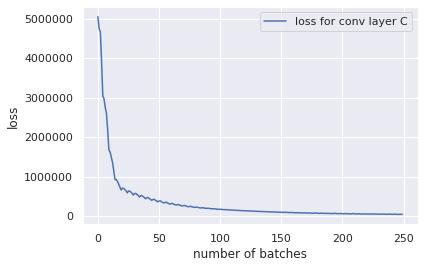

In [59]:
def plot_loss(loss_list):
    #plot loss_list 
    plt.plot(loss_list,label="loss for conv layer C")
    plt.legend()
    # x axis is the number of batches
    plt.xlabel("number of batches")
    plt.ylabel("loss")
    plt.show()

plot_loss(loss_list)


In [60]:
# output from trained C
output_C = []
generator = cifar_batch_generator()
for i in range(N_BATCHES):
    batch = next(generator)
    output_C.append(C.forward(batch))


In [61]:
# calculate the L2 loss
sum([l2_loss.forward(output_C0[i],output_C[i]) for i in range(N_BATCHES)])


224038.3337523802

In [62]:
C.weights = np.random.uniform(-1,1,size=(20,3,5,5))


generator = cifar_batch_generator()
loss_function = L2_loss()


In [63]:
batch = next(generator)
output_C = C.forward(batch)
loss = loss_function.forward(output_C0[0],output_C)
grad = loss_function.backward()
a = C.backward(grad)


In [64]:
np.max(C.weights - filter_weights)

1.9339866296782997